# Exploring data category-wise

## Set-up

In [1]:
try:
    # If we are not on google colab we need to upgrade pandas...
    from google.colab import widgets
    !pip install pandas --upgrade
except ModuleNotFoundError:
    # If we are not on google colab we pass
    pass


from distutils.version import LooseVersion
import pandas as pd
# As we are using features from pandas 0.23, we need to 
# check that the correct version is used.
assert LooseVersion(pd.__version__) > LooseVersion('0.23'), """
If you are on Google Colab and this fails, make sure you "restart runtime"
after running the cell that install the newest version of Pandas
If you are not on Google Colab and this fails, please update your
Pandas version: pip install --upgrade pandas
"""

In [2]:
# The block of code is here to make the notebook Google Colab compatible
try:
    # If we are not on google colab (we assume that you don't have 
    # the google.colab module on your computer...), 
    # the line below will raise an error that will be catch :)
    from google.colab import widgets
    # We clean the content of the directory, so that we can use
    #  git clone directly in it
    !rm -rf *
    !rm -rf .*
    !git clone https://github.com/striantafyllouEPFL/healthy-candies.git .
    # We get the data and initialize everything
    !python ./init_project.py
except ModuleNotFoundError:
    pass

In [3]:
import pandas as pd
import numpy as np

# Project specific module/functions
from healthy_candies.load import load_data
from healthy_candies.utils import plot_settings


import seaborn as sns
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Plot settings
plt.rcParams['figure.dpi'] = 100
sns.set_context('notebook')
sns.set()  # Use default seaborn styling for all plots

In [5]:
COL_NUTRI_CAT = 'nutrition_grade_fr'
COL_NUTRI_FLOAT = 'nutrition-score-fr_100g'
COL_MAIN_CAT = 'main_category'
COL_PRODUCT_NAME = 'product_name'
COL_CATEGORIES = 'categories_en'
COL_PROT = 'proteins_100g'

#Exploring the meat category

One of the first objectives we had in the first milestone was to explore some categories, and extract their relevant properties in terms of nutrition scores. 

Let's focus on meat products, and try to extract some  properties of this category using the nutritional rating. We have $\approx 11\, 000$ meat products with known nutriscores.

In [6]:
data = load_data(usecols=[COL_NUTRI_FLOAT,
                          COL_NUTRI_CAT,
                          COL_MAIN_CAT,
                          COL_PRODUCT_NAME,
                          COL_CATEGORIES,
                          COL_PROT],
                 limit_have_nutri_score=True)

In [7]:
# Extract (roughly) the meat category
meat = data[data[COL_CATEGORIES].str.contains("meat")]
meat.shape[0]

10718

Nutriscores of the meat category vary form -7 to 30 with a mean of $\approx 11$. We find in this category products with each of the different nutrition grades (A-E).  Let's consider a meat product with a nutriscore equal to 5: based only on this value, the product is labelled with a C nutriscore. We might be interested in comparing it to the other products of the same category: it would be better evaluated since its nutrition score is low compared to the average of meat products, which supports the idea of creating a new nutritional rating taking into consideration the category of the evaluated product as suggested in the first milestone.

In [8]:
def boxplot(df, x_col, y_col, title, xlabel, ylabel):
    ax = df[[x_col, y_col]] \
        .boxplot(by=x_col)
    ax.get_figure().suptitle('')
    plot_settings({
        'title': title,
        'xlabel': xlabel,
        'ylabel': ylabel
    })

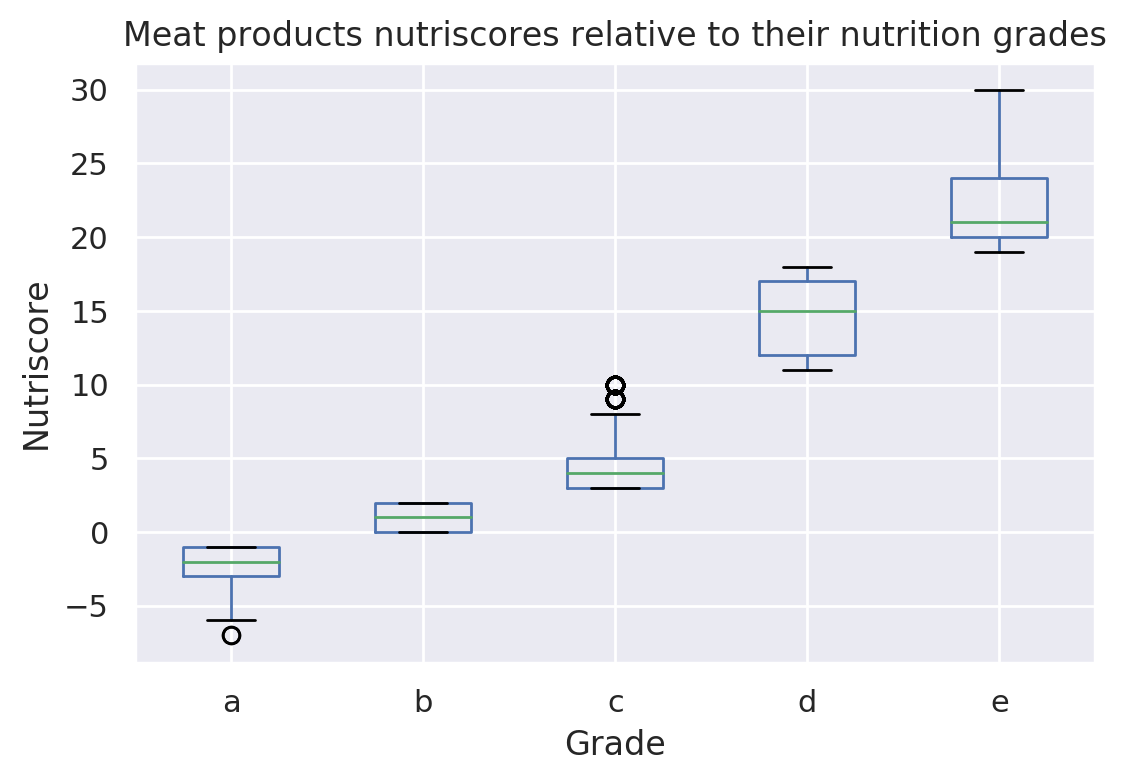

In [9]:
boxplot(meat,
        COL_NUTRI_CAT,
        COL_NUTRI_FLOAT,
        'Meat products nutriscores relative to their nutrition grades',
        'Grade', 'Nutriscore')

What a surprise ! Referring to the nutriscore, only $22$% of the meat category  is labelled as A-products or B-products and have a good nutritional quality,  while 28% of meat products are considered as really unhealthy (E class).

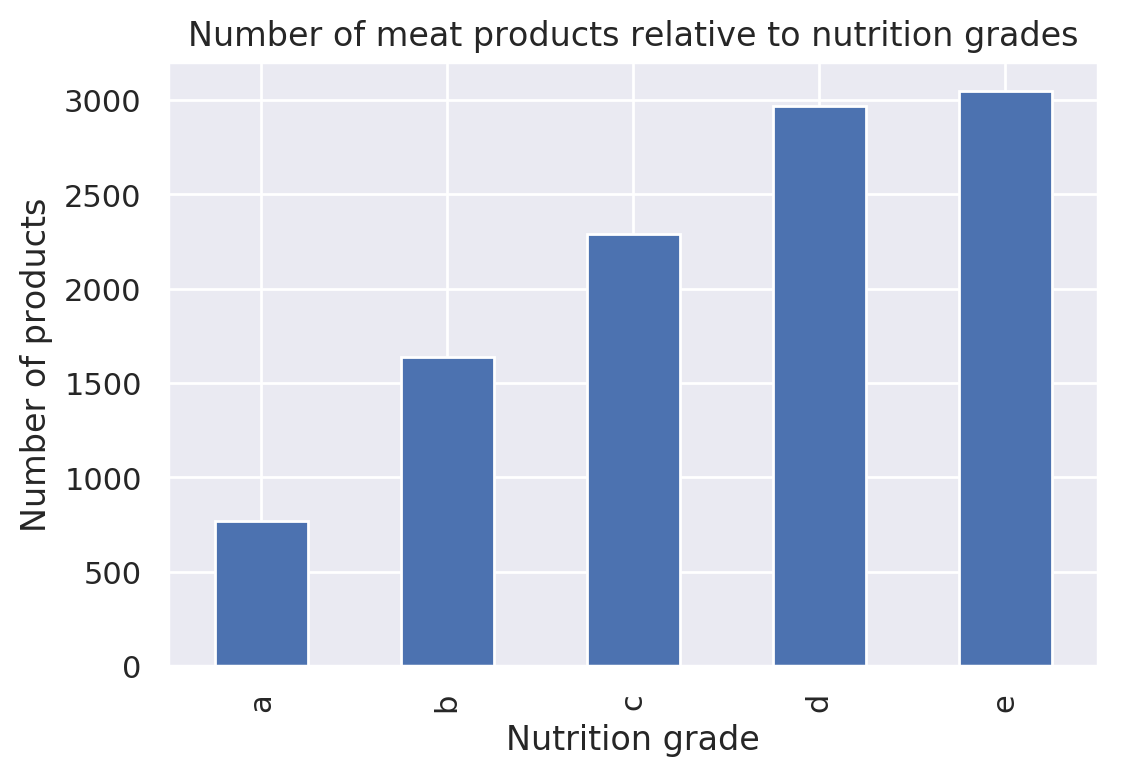

In [10]:
meat[COL_NUTRI_CAT] \
    .value_counts(ascending=True) \
    .plot.bar(color='b')

plot_settings({
    'title': "Number of meat products relative to nutrition grades",
    'xlabel': 'Nutrition grade',
    'ylabel': "Number of products"
})

**Subcategories: chicken and beef products**

Let's now take a closer look at the subcategories: chicken and beef products, to analyse how they differ from each other. We find in both subcategories products from all the nutritional groups (A-E), but chicken meals seem to have a better nutritional quality, since around $69$% of chicken products are labelled as A or B-products, while only $29$% of the beef category products are considered as healthy.

In [11]:
meat_cat = {}
meat_cat['chicken_products'] = meat[meat[COL_CATEGORIES].str.contains(
    "chicken")]
meat_cat['beef_products'] = meat[meat[COL_CATEGORIES].str.contains("beef")]

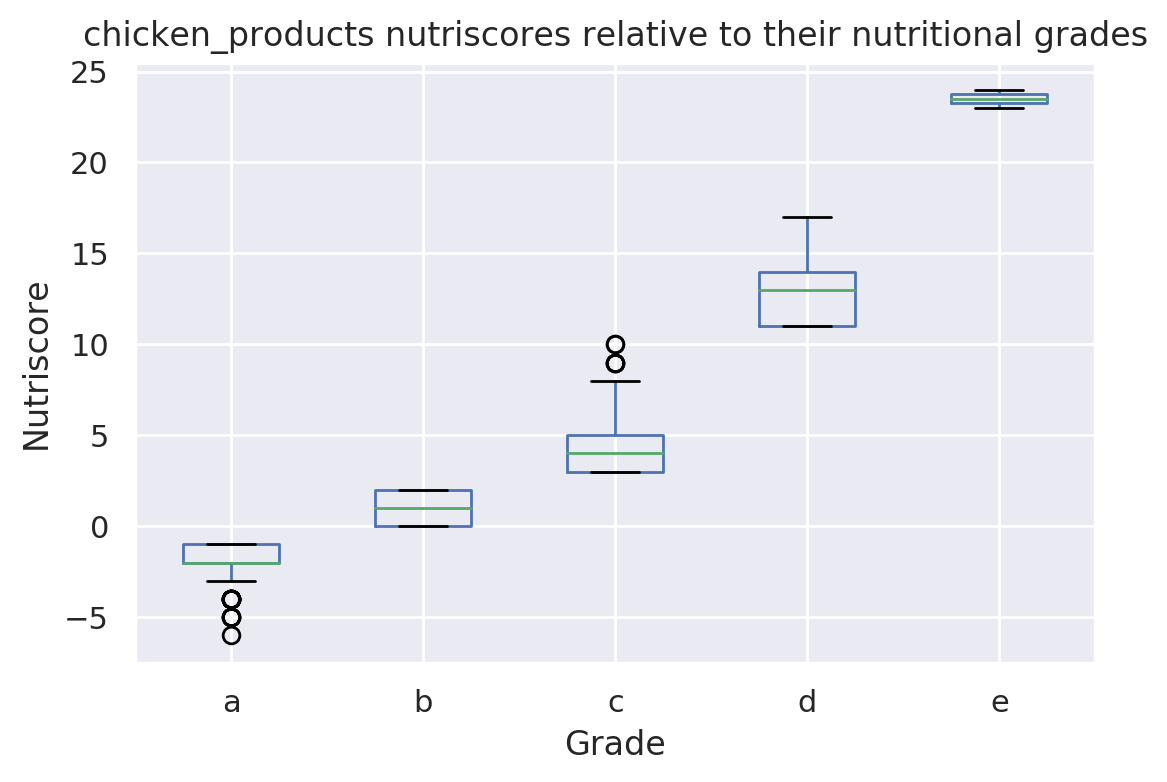

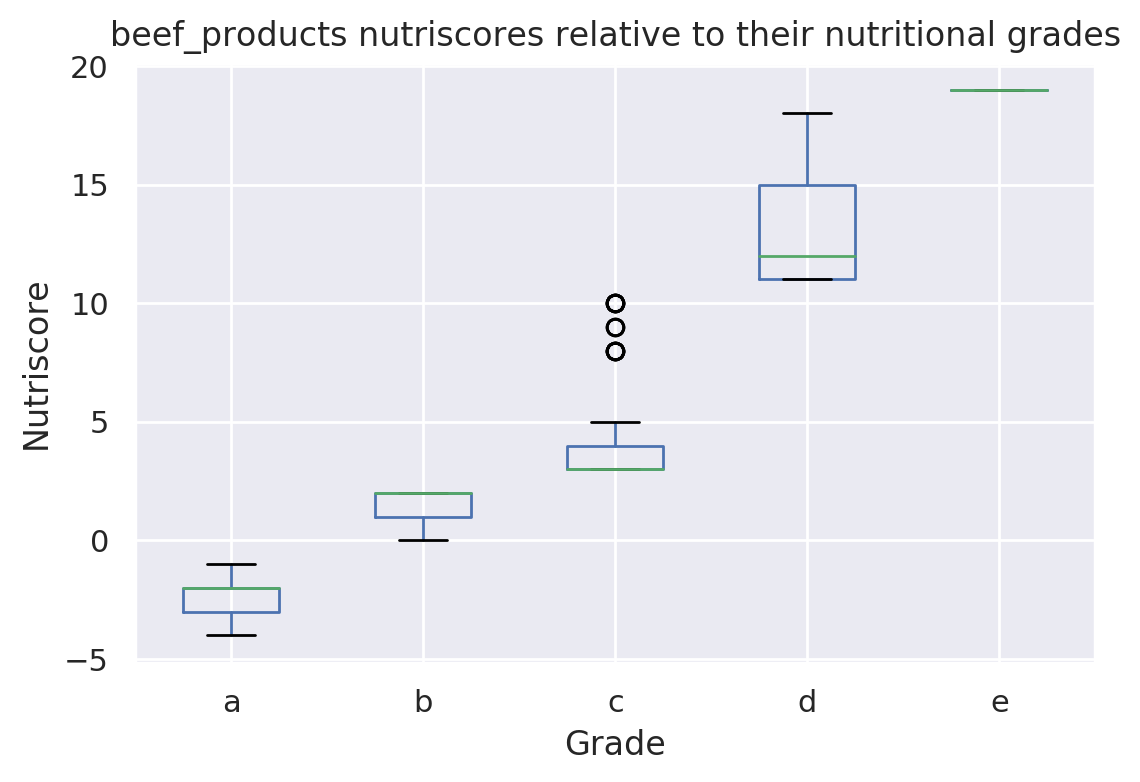

In [12]:
# Plot the distribution of the sub_categoreis nutriscores relative to their grades
for k in meat_cat.keys():
    boxplot(meat_cat[k],
            COL_NUTRI_CAT,
            COL_NUTRI_FLOAT,
            k + " nutriscores relative to their nutritional grades",
            'Grade', 'Nutriscore')

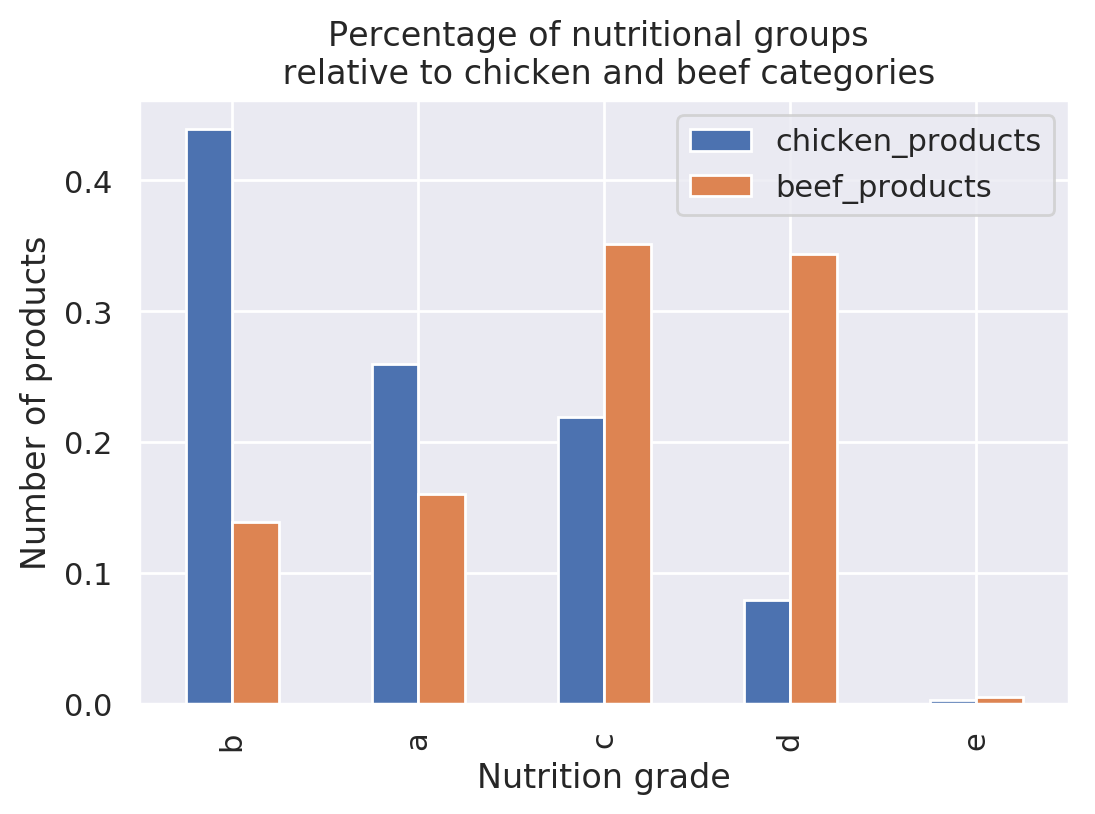

In [13]:
# df containing the percentage of nutrional groups (A-E) for chicken and beef categories
cat_count_df = pd.DataFrame()
for k in meat_cat.keys():
    cat_count = meat_cat[k][COL_NUTRI_CAT].value_counts()\
        .rename(k)
    cat_count_df = pd.concat(
        [cat_count_df, cat_count/cat_count.sum()], axis=1, sort=False)

# Plot the number of chicken and beef products relative to nutrition grades
cat_count_df.plot(use_index=True, kind="bar")
plot_settings({
    'title': "Percentage of nutritional groups \n relative to chicken and beef categories",
    'xlabel': "Nutrition grade",
    'ylabel': "Number of products",
})

From the nutriscore distribution above, we see that using only the nutriscores to draw conclusions on the properties of meat products, and to compare them is not sufficient. For that we will use another nutritional fact which is the protein present in  a portion of 100g of the product. 

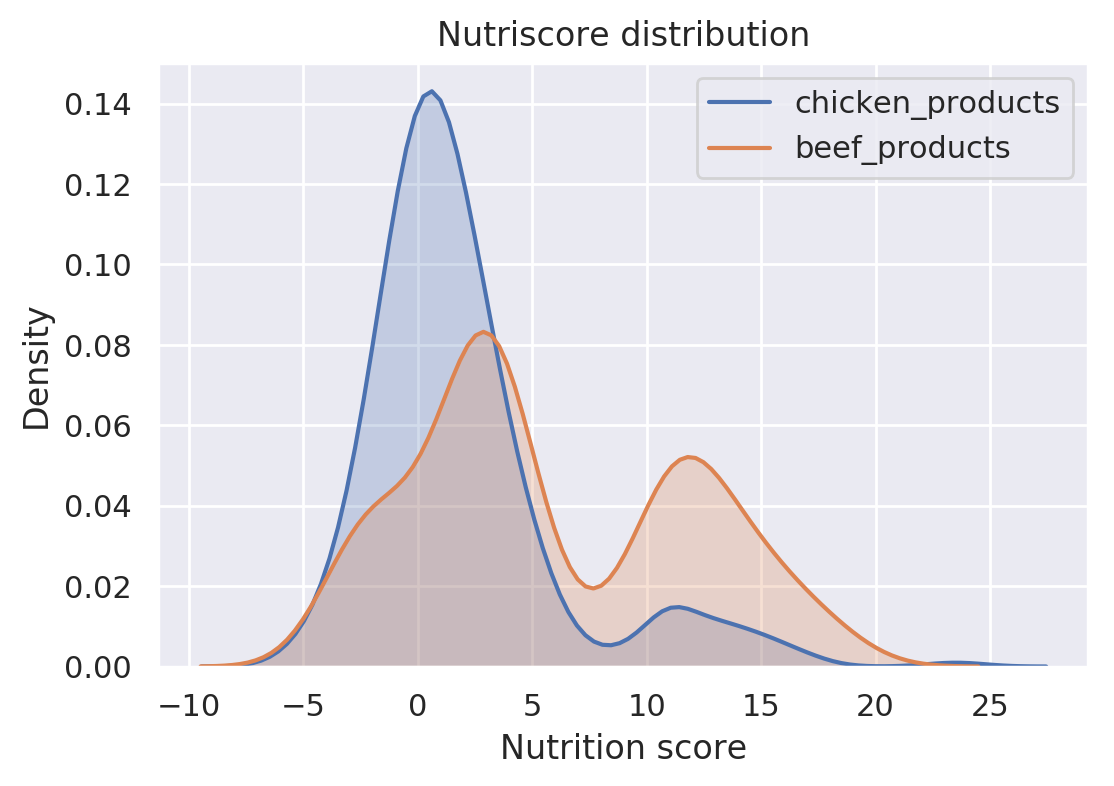

In [14]:
for k in meat_cat.keys():
    sns.kdeplot(meat_cat[k][COL_NUTRI_FLOAT], shade=True, label=k)

plot_settings({
    'title': "Nutriscore distribution",
    'xlabel': "Nutrition score",
    'ylabel': "Density",
})

Protein distributions in chicken and beef products are disjoint. From the plot below, we can conclude that beef  contain more protein than chicken. Thus we can characterize the meat category using the protein quantity in 100g of the products, and compare the different subcategories using this property.

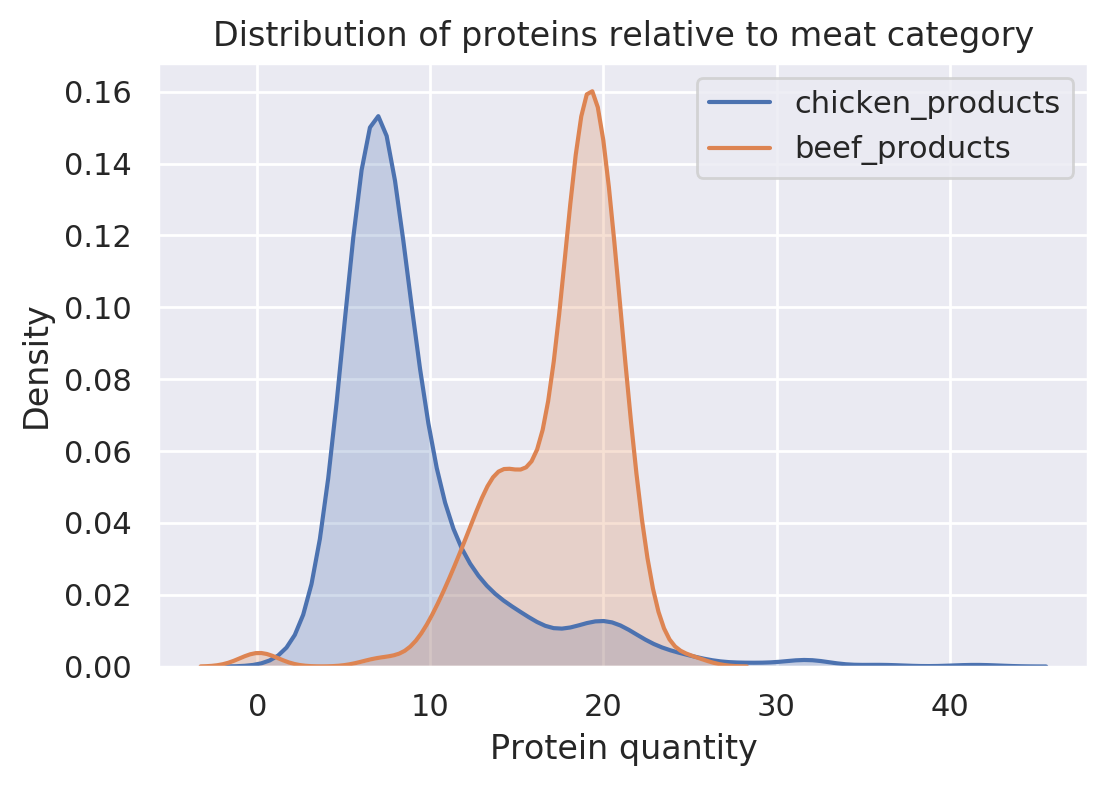

In [15]:
for k in meat_cat.keys():
    sns.kdeplot(meat_cat[k][COL_PROT], shade=True, label=k)

plot_settings({
    'title': "Distribution of proteins relative to meat category",
    'xlabel': "Protein quantity",
    'ylabel': "Density",
})

**Conclusion:**

We don't get enough insights on the categories products using only the nutritional rating. If we continue the project in that direction, it would be necessary to use some other nutritional facts to define the properties of each category, and to compare its products. These properties will be used in creating another nutritional rating.